In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
def read_apbs_dx(filename):
    """Robust APBS DX reader - handles all common formats."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    origin = np.zeros(3)
    delta = np.ones(3) * 0.25  # Default 0.25Å from your APBS
    counts = np.zeros(3, dtype=int)
    data = []
    
    # Parse header line-by-line
    for line in lines:
        line = line.strip()
        
        # Origin: "origin =  x y z"
        if line.startswith('origin'):
            nums = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', line)
            if len(nums) >= 3:
                origin = np.array([float(nums[0]), float(nums[1]), float(nums[2])])
        
        # Counts: "object 1 class gridpositions counts nx ny nz"
        if 'class gridpositions counts' in line:
            nums = re.findall(r'\d+', line)
            if len(nums) >= 3:
                counts = np.array([int(nums[-3]), int(nums[-2]), int(nums[-1])])
        
        # Delta: 3 lines after "delta =", last number each line
        if line.startswith('delta') and '=' in line:
            nums = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', line)
            if nums:
                delta[0] = float(nums[-1])
        
        # Data starts after "array type float"
        if 'array type float' in line:
            break
        data_start = len(data)
    
    # Read all numeric data
    for line in lines:
        nums = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', line)
        data.extend([float(x) for x in nums])
    
    # Reshape (APBS uses Fortran order: z,y,x → x,y,z)
    if len(data) != np.prod(counts):
        print(f"Warning: expected {np.prod(counts)} values, got {len(data)}")
    
    potential = np.array(data[:int(np.prod(counts))]).reshape(counts[::-1], order='F')
    
    print(f"✓ Loaded {filename}")
    print(f"  Shape: {potential.shape}")
    print(f"  Origin: [{origin[0]:.3f}, {origin[1]:.3f}, {origin[2]:.3f}]")
    print(f"  Delta:  [{delta[0]:.3f}, {delta[1]:.3f}, {delta[2]:.3f}] Å")
    print(f"  Range:  {potential.min():.3f} → {potential.max():.3f} kT/e")
    
    return potential, origin, delta, counts

In [3]:
def extract_active_site(potential, origin, delta, center, box_size=20.0):
    """Extract region around center coordinates."""
    half = box_size / 2
    
    # Grid indices
    i_slice = slice(
        max(0, int((center[0] - origin[0] - half) / delta[0])),
        min(potential.shape[0], int((center[0] - origin[0] + half) / delta[0]))
    )
    j_slice = slice(
        max(0, int((center[1] - origin[1] - half) / delta[1])),
        min(potential.shape[1], int((center[1] - origin[1] + half) / delta[1]))
    )
    k_slice = slice(
        max(0, int((center[2] - origin[2] - half) / delta[2])),
        min(potential.shape[2], int((center[2] - origin[2] + half) / delta[2]))
    )
    
    region = potential[i_slice, j_slice, k_slice]
    
    print(f"✓ Active site: {region.shape} voxels ({box_size}Å cube)")
    return region

In [5]:
dx_ido = "ido_active_single.dx"
center = [112.166, -5.097, 155.369]  # Your APBS center

In [6]:
dx_tdo = "tdo_active_single.dx"
center = [37.631, -61.835, -32.297]  # Your APBS center

In [7]:
pot, origin, delta, dims = read_apbs_dx(dx_ido)

✓ Loaded ido_active_single.dx
  Shape: (161, 161, 161)
  Origin: [92.166, -25.097, 135.369]
  Delta:  [0.250, 0.250, 0.250] Å
  Range:  -561.662 → 4173281.000 kT/e


In [8]:
pot, origin, delta, dims = read_apbs_dx(dx_tdo)

✓ Loaded tdo_active_single.dx
  Shape: (161, 161, 161)
  Origin: [17.631, -81.835, -52.297]
  Delta:  [0.250, 0.250, 0.250] Å
  Range:  -37530.870 → 4173281.000 kT/e


In [9]:
active_site = extract_active_site(pot, origin, delta, center)

✓ Active site: (80, 80, 80) voxels (20.0Å cube)


In [104]:
# Save your 3D matrix
np.save("ido_active_site.npy", active_site)
print("\n🎉 active_site.npy ready!")
print(f"Load with: data = np.load('active_site.npy')")


🎉 active_site.npy ready!
Load with: data = np.load('active_site.npy')


In [10]:
data = np.load("tdo_active_site.npy")  # Your 3D matrix

In [11]:
active_site.shape

(80, 80, 80)

In [12]:
def project_3d_to_2d_potential(potential_3d, method='max', plane='xy'):
    """
    Convert 3D electrostatic potential to 2D while preserving gradient.
    
    Methods:
    - 'max': Maximum intensity projection (best for visualization)
    - 'mean': Average projection  
    - 'sum': Integrated projection
    """
    if method == 'max':
        if plane == 'xy':
            proj_2d = np.max(potential_3d, axis=2)  # Max along Z
        elif plane == 'xz':
            proj_2d = np.max(potential_3d, axis=1)  # Max along Y
        else:  # xz
            proj_2d = np.max(potential_3d, axis=0)  # Max along X
    
    elif method == 'mean':
        if plane == 'xy':
            proj_2d = np.mean(potential_3d, axis=2)
        elif plane == 'xz':
            proj_2d = np.mean(potential_3d, axis=1)
        else:
            proj_2d = np.mean(potential_3d, axis=0)
    
    else:  # sum
        if plane == 'xy':
            proj_2d = np.sum(potential_3d, axis=2)
        elif plane == 'xz':
            proj_2d = np.sum(potential_3d, axis=1)
        else:
            proj_2d = np.sum(potential_3d, axis=0)
    
    return proj_2d

In [13]:
def visualize_2d_potential(proj_2d, title="Active Site Electrostatic Potential", 
                          cmap='RdBu', vmin=-5, vmax=5):
    """Create beautiful colormap visualization."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    im = ax.imshow(proj_2d, cmap=cmap, vmin=vmin, vmax=vmax, 
                   origin='lower', interpolation='bilinear')
    
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X Grid Points')
    ax.set_ylabel('Y Grid Points')
    
    # Colorbar with kT/e units
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Electrostatic Potential (kT/e)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [14]:
# Load your 3D active site data
active_site_3d = np.load("tdo_active_site.npy")
print(f"3D shape: {active_site_3d.shape}")

3D shape: (80, 80, 80)


In [15]:
# Project to 2D (XY plane, maximum projection preserves gradients best)
proj_xy_max = project_3d_to_2d_potential(active_site_3d, method='max', plane='xy')
proj_xy_mean = project_3d_to_2d_potential(active_site_3d, method='mean', plane='xy')
    
print(f"2D XY max projection: {proj_xy_max.shape}")
print(f"Range: {proj_xy_max.min():.3f} → {proj_xy_max.max():.3f} kT/e")

2D XY max projection: (80, 80)
Range: -76.619 → 1906.376 kT/e


In [ ]:
# Save 2D matrices
np.save("active_site_2d_xy_max.npy", proj_xy_max)
np.save("active_site_2d_xy_mean.npy", proj_xy_mean)

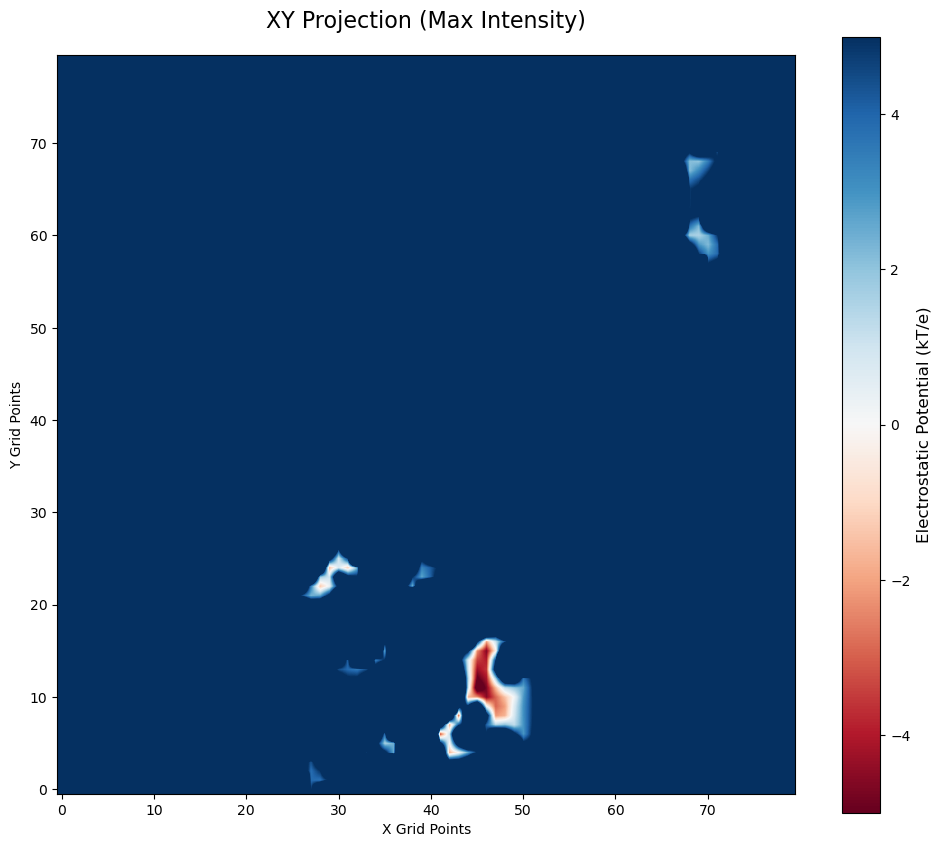

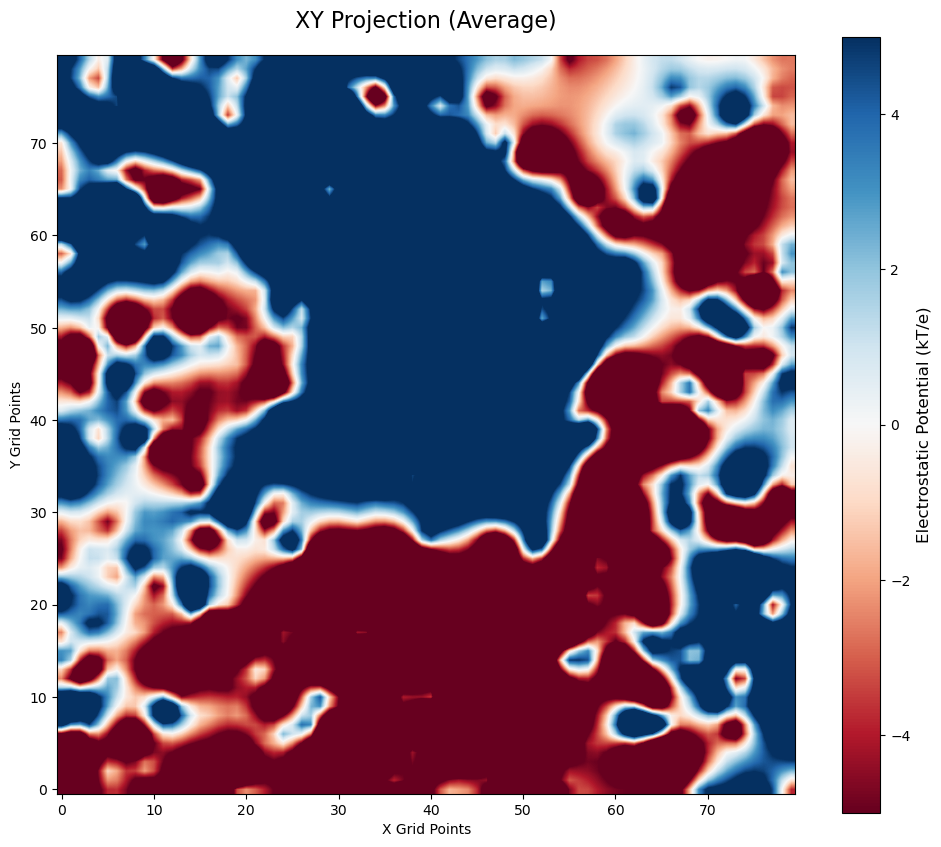

In [108]:
# Visualize IDO active site in XY plane
fig1, _ = visualize_2d_potential(proj_xy_max, "XY Projection (Max Intensity)", vmin=-5, vmax=5)
    
fig2, _ = visualize_2d_potential(proj_xy_mean, "XY Projection (Average)", vmin=-5, vmax=5)
    
plt.show()

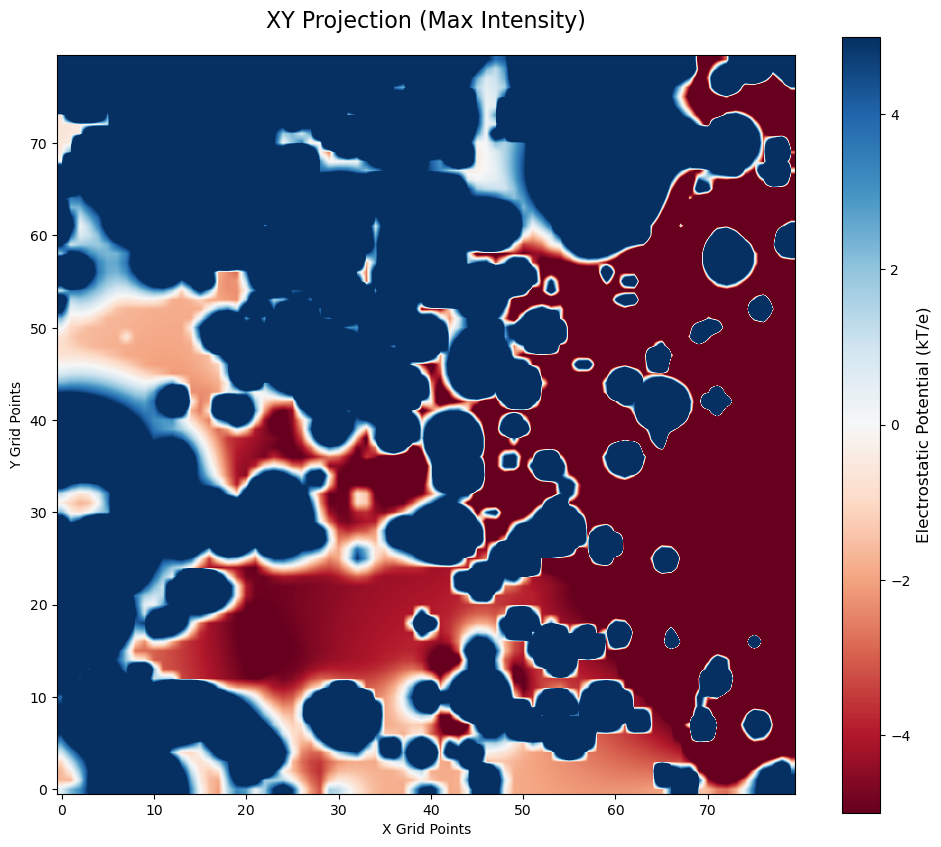

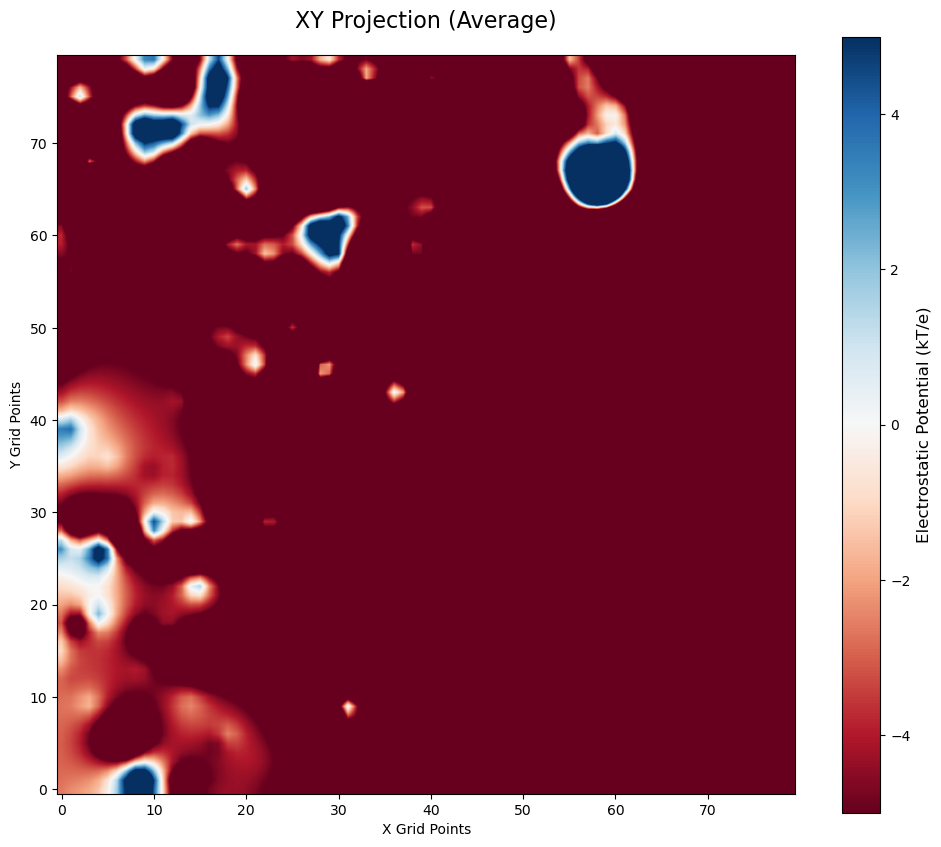

In [16]:
# Visualize TDO active site in XY plane
fig1, _ = visualize_2d_potential(proj_xy_max, "XY Projection (Max Intensity)", vmin=-5, vmax=5)
    
fig2, _ = visualize_2d_potential(proj_xy_mean, "XY Projection (Average)", vmin=-5, vmax=5)
    
plt.show()

In [81]:
fig1.savefig("tdo_max_site.png")

In [82]:
fig2.savefig("tdo_mean_site.png")